In [22]:
import os
import warnings
import logging

# Suppress multiprocess dataloader errors and warnings
os.environ["PYTHONWARNINGS"] = "ignore"
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)


In [2]:
!pip install librosa
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install tqdm
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
!wget -c https://os.unil.cloud.switch.ch/fma/fma_small.zip
!unzip -q fma_small.zip

!wget -c https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip -q fma_metadata.zip


--2025-04-30 04:12:01--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  22.4MB/s    in 5m 17s  

2025-04-30 04:17:19 (23.1 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]

--2025-04-30 04:27:20--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81

In [4]:
import pandas as pd

tracks = pd.read_csv("fma_metadata/tracks.csv", index_col=0, header=[0, 1])
genre_labels = tracks['track']['genre_top']
genre_labels = genre_labels.dropna()

# Map genre strings to integers
genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(genre_labels.unique()))}
idx_to_genre = {v: k for k, v in genre_to_idx.items()}

print(tracks.columns.levels)  # Shows top-level and second-level column names

print(genre_labels.head(10))

print(f"\nTotal labeled tracks: {len(genre_labels)}")

print("\nGenre to index mapping:")
for genre, idx in genre_to_idx.items():
    print(f"{genre}: {idx}")

print("\nGenre to index mapping:")
for genre, idx in genre_to_idx.items():
    print(f"{genre}: {idx}")



[['album', 'artist', 'set', 'track'], ['active_year_begin', 'active_year_end', 'associated_labels', 'bio', 'bit_rate', 'comments', 'composer', 'date_created', 'date_recorded', 'date_released', 'duration', 'engineer', 'favorites', 'genre_top', 'genres', 'genres_all', 'id', 'information', 'interest', 'language_code', 'latitude', 'license', 'listens', 'location', 'longitude', 'lyricist', 'members', 'name', 'number', 'producer', 'publisher', 'related_projects', 'split', 'subset', 'tags', 'title', 'tracks', 'type', 'website', 'wikipedia_page']]
track_id
2           Hip-Hop
3           Hip-Hop
5           Hip-Hop
10              Pop
134         Hip-Hop
135            Rock
136            Rock
137    Experimental
138    Experimental
139            Folk
Name: genre_top, dtype: object

Total labeled tracks: 49598

Genre to index mapping:
Blues: 0
Classical: 1
Country: 2
Easy Listening: 3
Electronic: 4
Experimental: 5
Folk: 6
Hip-Hop: 7
Instrumental: 8
International: 9
Jazz: 10
Old-Time / Histori

In [5]:
import librosa
import numpy as np
import os

def extract_mel_spectrogram(filepath, n_mels=128, duration=30, sr=22050):
    y, _ = librosa.load(filepath, sr=sr, duration=duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db


In [14]:
import torch
from torch.utils.data import Dataset

class FMADataset(Dataset):
    def __init__(self, mel_dir, track_ids, genre_map):
        self.file_paths = []
        self.labels = []
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(genre_map.unique()))}

        for tid in track_ids:
            genre = genre_map.loc[tid]
            mel_path = os.path.join(mel_dir, f"{tid}.npy")
            if not os.path.isfile(mel_path):
                continue
            self.file_paths.append(mel_path)
            self.labels.append(self.genre_to_idx[genre])


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mel = np.load(self.file_paths[idx])
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label


In [15]:
from torch.utils.data import random_split, DataLoader
import os

# Step 1: Get valid .mp3 files that also have genre labels
usable_ids = []
for root, _, files in os.walk("fma_small"):
    for f in files:
        if f.endswith(".mp3"):
            tid = int(f[:-4])
            if tid in genre_labels.index:
                usable_ids.append(tid)

print(f"Final usable tracks with both audio and labels: {len(usable_ids)}")

# Step 2: Filter genre labels to these IDs
filtered_genre_labels = genre_labels.loc[usable_ids]

# Step 3: Build dataset
track_ids = filtered_genre_labels.index.tolist()
subset_labels = filtered_genre_labels

# Optional: Subset
#track_ids = track_ids[:1000]
subset_labels = filtered_genre_labels

dataset = FMADataset('mel_spectrograms', track_ids, subset_labels)

# Step 4: Split and load
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

print("Genre-labeled track IDs:", len(genre_labels))
print("Filtered genre-labeled + .mp3 track IDs:", len(filtered_genre_labels))



Final usable tracks with both audio and labels: 8000
Genre-labeled track IDs: 49598
Filtered genre-labeled + .mp3 track IDs: 8000


In [9]:
from multiprocessing import Pool
from tqdm import tqdm

def process_track(tid):
    folder = f"{tid:06d}"[:3]
    filename = f"{tid:06d}.mp3"
    filepath = os.path.join("fma_small", folder, filename)
    mel_root = "mel_spectrograms"
    os.makedirs(mel_root, exist_ok=True)

    if not os.path.isfile(filepath):
        return

    try:
        mel = extract_mel_spectrogram(filepath)
        fixed_length = 1280
        if mel.shape[1] < fixed_length:
            mel = np.pad(mel, ((0, 0), (0, fixed_length - mel.shape[1])), mode='constant')
        elif mel.shape[1] > fixed_length:
            mel = mel[:, :fixed_length]
        np.save(os.path.join(mel_root, f"{tid}.npy"), mel)
    except Exception as e:
        print(f"Error processing {filepath}: {e}")

# Then call it:
with Pool() as pool:
    list(tqdm(pool.imap(process_track, track_ids), total=len(track_ids)))


 15%|█▌        | 1228/8000 [03:19<22:15,  5.07it/s]

Error processing fma_small/099/099134.mp3: 


 52%|█████▏    | 4122/8000 [10:51<08:09,  7.93it/s]

Error processing fma_small/108/108925.mp3: 


 84%|████████▎ | 6689/8000 [17:31<04:20,  5.03it/s]

Error processing fma_small/133/133297.mp3: 


100%|██████████| 8000/8000 [20:54<00:00,  6.38it/s]


In [16]:
import torch.nn as nn

class GenreCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),

            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define number of classes from your label mapping
num_classes = len(genre_to_idx)

# Model, loss, and optimizer
model = GenreCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Training function
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(loader):
        inputs, labels = batch
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i == 0 or i == 199:
          print(f"Batch {i+1}/{len(loader)} - Loss: {loss.item():.4f}")

    return running_loss / len(loader)

train_losses = []

# Training loop
epochs = 100
for epoch in range(epochs):
    avg_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}\n")
    scheduler.step()

torch.save(model.state_dict(), "harmonianet.pth")



Batch 1/200 - Loss: 2.8068
Batch 200/200 - Loss: 1.3826
Epoch 1/100 - Average Loss: 1.8081

Batch 1/200 - Loss: 1.4578
Batch 200/200 - Loss: 1.5241
Epoch 2/100 - Average Loss: 1.5734

Batch 1/200 - Loss: 1.4851
Batch 200/200 - Loss: 1.8003
Epoch 3/100 - Average Loss: 1.4931

Batch 1/200 - Loss: 1.2469
Batch 200/200 - Loss: 1.1868
Epoch 4/100 - Average Loss: 1.4389

Batch 1/200 - Loss: 1.3360
Batch 200/200 - Loss: 1.1926
Epoch 5/100 - Average Loss: 1.4023

Batch 1/200 - Loss: 1.4877
Batch 200/200 - Loss: 1.2896
Epoch 6/100 - Average Loss: 1.3668

Batch 1/200 - Loss: 1.2351
Batch 200/200 - Loss: 1.6218
Epoch 7/100 - Average Loss: 1.3433

Batch 1/200 - Loss: 1.7224
Batch 200/200 - Loss: 1.8216
Epoch 8/100 - Average Loss: 1.3199

Batch 1/200 - Loss: 1.1233
Batch 200/200 - Loss: 1.4877
Epoch 9/100 - Average Loss: 1.3041

Batch 1/200 - Loss: 0.9318
Batch 200/200 - Loss: 1.6709
Epoch 10/100 - Average Loss: 1.2985

Batch 1/200 - Loss: 1.4072
Batch 200/200 - Loss: 1.1575
Epoch 11/100 - Average 

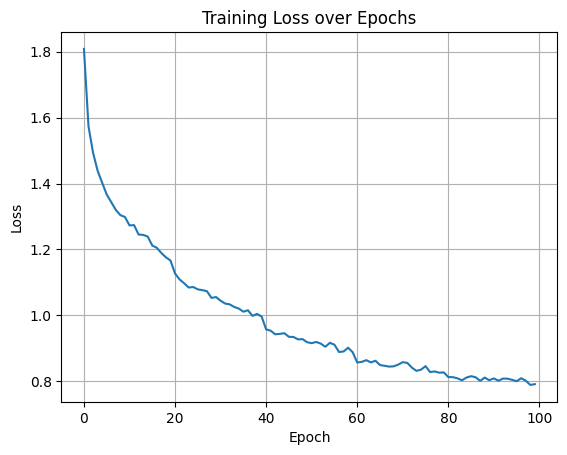

In [37]:
import matplotlib.pyplot as plt

# Plot training curve
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Validation Accuracy: 61.00%


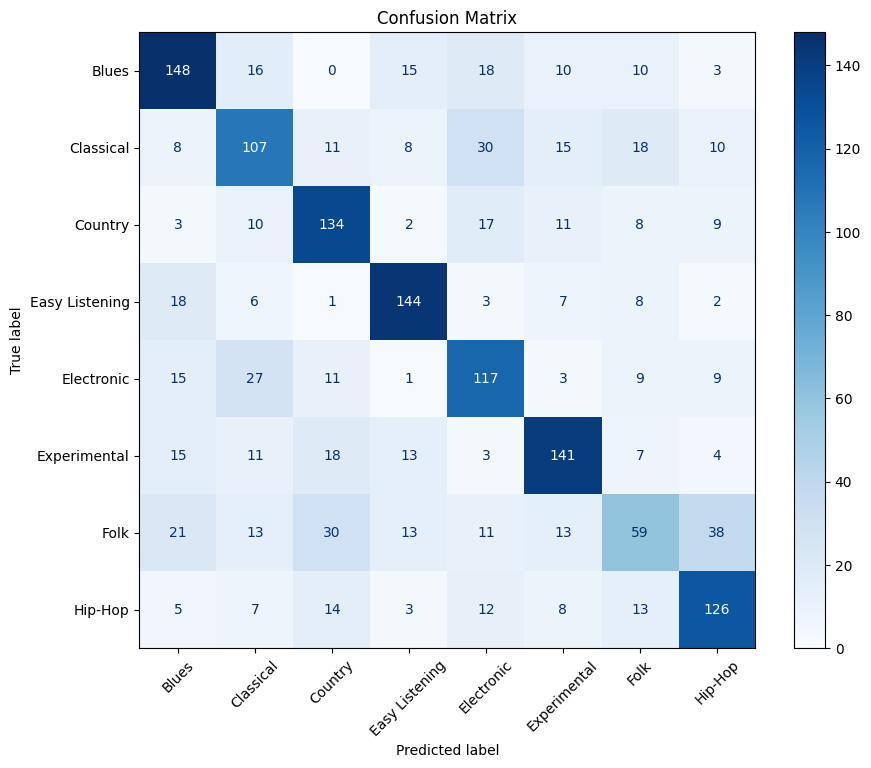

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, dtype=torch.float32), y.to(device)
            output = model(x)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            correct += (pred == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.2%}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    used_genres = sorted(set(dataset.labels))
    display_labels = [idx_to_genre[i] for i in used_genres]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

evaluate(model, val_loader)



In [39]:
# Zip the directory or file
!zip -r harmonianet_outputs.zip mel_spectrograms harmonianet.pth

# Then download
from google.colab import files
files.download('harmonianet_outputs.zip')


Streaming output truncated to the last 5000 lines.
  adding: mel_spectrograms/134942.npy (deflated 14%)
  adding: mel_spectrograms/50276.npy (deflated 15%)
  adding: mel_spectrograms/123485.npy (deflated 23%)
  adding: mel_spectrograms/6802.npy (deflated 16%)
  adding: mel_spectrograms/142516.npy (deflated 16%)
  adding: mel_spectrograms/83789.npy (deflated 15%)
  adding: mel_spectrograms/137716.npy (deflated 15%)
  adding: mel_spectrograms/40938.npy (deflated 14%)
  adding: mel_spectrograms/106342.npy (deflated 21%)
  adding: mel_spectrograms/123966.npy (deflated 15%)
  adding: mel_spectrograms/93921.npy (deflated 27%)
  adding: mel_spectrograms/68899.npy (deflated 14%)
  adding: mel_spectrograms/139536.npy (deflated 32%)
  adding: mel_spectrograms/147268.npy (deflated 22%)
  adding: mel_spectrograms/124201.npy (deflated 14%)
  adding: mel_spectrograms/20432.npy (deflated 14%)
  adding: mel_spectrograms/62190.npy (deflated 14%)
  adding: mel_spectrograms/125681.npy (deflated 35%)
  ad

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to Google Drive
!cp harmonianet.pth /content/drive/MyDrive/

# Save processed spectrograms too (optional but large!)
!cp -r mel_spectrograms /content/drive/MyDrive/


Mounted at /content/drive
